In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Importacion de librerias

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import random
import IPython.display as display
from random import randint

# Configuraciones de TensorFlow

### Configuracion de TensorFlow 2.0

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

### Configuracion de TensorFlow 1.0

In [ ]:
#Log device placement corresponde a si yo quiero ver la informacion en donde se mapea o guardan las variables que creo
config = tf.ConfigProto(log_device_placement=True)

In [ ]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

### Modo eagerly

In [4]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

True

# Carga de Datos

### Exploracion Dataset

In [6]:
root_path = pathlib.Path("../DataSets/ucf101")
root_path

PosixPath('../DataSets/UCF101')

In [8]:
videos_rgb_path = list(root_path.glob('frames/*'))
videos_rgb_path = [str(video) for video in videos_rgb_path]
len(videos_rgb_path)

13320

In [9]:
videos_rgb_path[:10]

['../DataSets/UCF101/frames/v_PlayingPiano_g24_c04',
 '../DataSets/UCF101/frames/v_RopeClimbing_g20_c02',
 '../DataSets/UCF101/frames/v_BlowingCandles_g18_c01',
 '../DataSets/UCF101/frames/v_Rowing_g05_c04',
 '../DataSets/UCF101/frames/v_Archery_g23_c07',
 '../DataSets/UCF101/frames/v_HeadMassage_g16_c04',
 '../DataSets/UCF101/frames/v_JumpingJack_g07_c04',
 '../DataSets/UCF101/frames/v_Shotput_g08_c07',
 '../DataSets/UCF101/frames/v_Skiing_g16_c04',
 '../DataSets/UCF101/frames/v_PlayingCello_g09_c05']

In [10]:
video_path = pathlib.Path(random.choice(videos_rgb_path))
frames_path = list(video_path.glob('*'))
frames_path = [str(frame_path) for frame_path in frames_path]
print(video_path)

../DataSets/UCF101/frames/v_HandstandPushups_g16_c07


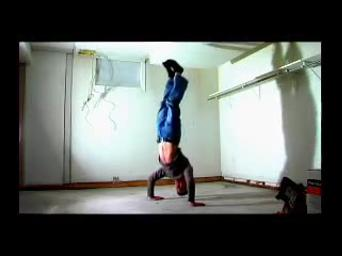

In [11]:
display.display(display.Image(random.choice(frames_path)))

In [12]:
nombres_clases = sorted(pathlib.Path(item).name for item in videos_rgb_path if pathlib.Path(item).is_dir())
nombres_clases = [clase.split("_")[1] for clase in nombres_clases]

#Extraccion de todos los tipos de clases en un vector de python
clases = []
for clase in nombres_clases:
    if clase not in clases:
        clases.append(clase)

#label_names, __ = tf.unique(label_names)
nombres_clases = clases
nombres_clases[:10]

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [13]:
clase_a_numero = dict((name, index) for index,name in enumerate(nombres_clases))
len(clase_a_numero)

101

In [14]:
clases_videos = [clase_a_numero[pathlib.Path(item).name.split("_")[1]] for item in videos_rgb_path]
clases_videos[:10]

[63, 74, 13, 75, 2, 38, 47, 78, 80, 58]

### Organizacion del Dataset

In [ ]:
%cd ../DataSets

os.mkdir("ucf101")

In [ ]:
os.mkdir("ucf101/frames")

In [ ]:
videos_rgb_path

### Como cargar los videos usando la libreria de tensorflow

In [ ]:
#Forma de cargar los videos para usarlos como dataset pero ocupa mucha memoria, entonces se va hacer buffering con tensor
videos = []
for video_path in videos_rgb_path:
    video = []
    for frame_path in sorted(list(video_path.glob('*'))):
        frame_raw = tf.io.read_file(str(frame_path))
        frame_tensor = tf.image.decode_image(frame_raw, channels=3)
        frame_tensor = tf.image.resize(frame_tensor,[128,171])
        frame_tensor = seleccionar_cuadro_aleatorio(frame_tensor, 112)
        video.append(frame_tensor)
    video = tf.convert_to_tensor(video)
    video = seleccionar_extension_temporal(video, 16)
    videos.append(video)
videos = tf.convert_to_tensor(videos)

In [15]:
def seleccionar_cuadro_aleatorio(imagen, nueva_dimension):
    pos_y = randint(0,imagen.shape[0].value - nueva_dimension)
    pos_x = randint(0,imagen.shape[1].value - nueva_dimension)
    return imagen[pos_y : pos_y + nueva_dimension , pos_x : pos_x + nueva_dimension, :]

In [16]:
def seleccionar_extension_temporal(video, nro_frames):
    extension = randint(0,video.shape[0].value - nro_frames)
    return video[extension : extension + nro_frames, : , :, :]

In [ ]:
#Funcion sin ser usada aun
def procesar_frame(frame_path):
    frame_raw = tf.io.read_file(str(frame_path))
    frame_tensor = tf.image.decode_image(frame_raw, channels=3)
    frame_tensor = tf.image.resize(frame_tensor,[128,171])
    return frame_tensor

In [17]:
def cargar_preprocesar_video(video_path):
    video = []
    for frame_path in sorted(list(pathlib.Path(video_path.numpy()).glob('*'))):
        frame_raw = tf.io.read_file(str(frame_path))
        frame_tensor = tf.image.decode_image(frame_raw, channels=3)
        frame_tensor = tf.image.resize(frame_tensor,[128,171])
        frame_tensor = seleccionar_cuadro_aleatorio(frame_tensor, 112)
        video.append(frame_tensor)
    video = tf.convert_to_tensor(video)
    video = seleccionar_extension_temporal(video, 16)
    return video

### Creacion de los datasets de TensorFlow

In [18]:
#Construccion del dataset a partir de los path y cargar los datos usando prefetch
videos_rgb_path_ds = tf.data.Dataset.from_tensor_slices(videos_rgb_path)
videos_rgb_path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [19]:
videos_ds = videos_rgb_path_ds.map(cargar_preprocesar_video, num_parallel_calls=tf.data.experimental.AUTOTUNE)

AttributeError: in converted code:

    <ipython-input-17-f22c65689ba7>:3 cargar_preprocesar_video  *
        for frame_path in sorted(list(pathlib.Path(video_path.numpy()).glob('*'))):

    AttributeError: 'Tensor' object has no attribute 'numpy'


### Convertir los tensores a texto con tf.data

In [ ]:
directories_ds = tf.data.Dataset.list_files(videos_rgb_path[0]+"/*")

for video in directories_ds:
    print(video)

In [ ]:
videos_rgb_path_ds = tf.data.TextLineDataset(videos_rgb_path_ds)
videos_rgb_path_ds

In [ ]:
for video in videos_rgb_path_ds:
    frames = tf.data.TextLineDataset(video)
    #print(frames)
    #print(frames.list_files("*"))
    for frame in frames.list_files("*"):
        print(frame)
    break

In [ ]:
tf.data.get_output_stype(videos_rgb_path_ds)

In [ ]:
videos_rgb_path_ds.list_files("*")

### Listar directorios usando la libreria tf.io.gfile

In [ ]:
for elemento in videos_rgb_path_ds:
    print(elemento)
    #print(tf.io.gfile.listdir(elemento))
    break

In [ ]:
https://stackoverflow.com/questions/44416764/loading-folders-of-images-in-tensorflow
https://github.com/hx173149/C3D-tensorflow
https://gist.github.com/tomrunia/7ef5d40639f2ae41fb71d3352a701e4a
https://github.com/ferreirafabio/video2tfrecord
https://stackoverflow.com/questions/42978731/video-frames-as-inputs-to-the-tensorflow-graph

In [ ]:

tf.io.gfile.listdir(tf.constant("../DataSets/UCF101/frames/v_PlayingPiano_g24_c04"))

In [ ]:
videos_ds = videos_rgb_path_ds.map(cargar_preprocesar_video, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
etiquetas_ds = tf.data.Dataset.from_tensor_slices(clases_videos)
etiquetas_ds

In [ ]:
tf.version.VERSION

# Red Neuronal

In [ ]:
from LTC import LTC



model = LTC(
    entrada = None,
    etiquetas = None,
    num_clases = None,
    batch_size = 30,
    dropout = 0.5,
    entramiento = True):

logging_hook = tf.train.LoggingTensorHook(
      tensors={'step': model.global_step,
               'loss': model.cost,
               'precision': precision},
      every_n_iter=100)

training_session = tf.train.MonitoredTrainingSession(
    checkpoint_dir="./Checkpoints",
      hooks=[logging_hook, _LearningRateSetterHook()],
      chief_only_hooks=[summary_hook],
      # Since we provide a SummarySaverHook, we need to disable default
      # SummarySaverHook. To do that we set save_summaries_steps to 0.
      save_summaries_steps=0,
      config=config
)

In [ ]:
https://www.math.purdue.edu/~nwinovic/slides/Getting_Started_with_TensorFlow_II.pdf